# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install qiskit --upgrade
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'2.0.0'

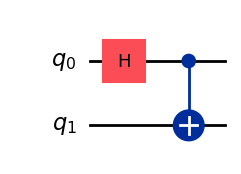

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.       , -0.0234375, -0.0234375,  1.       ,  0.015625 ,
        0.015625 ]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0050127, 'sample_measure_time': 0.0014311, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.99945068359375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0050127, 'sample_measure_time': 0.0014311, 'in

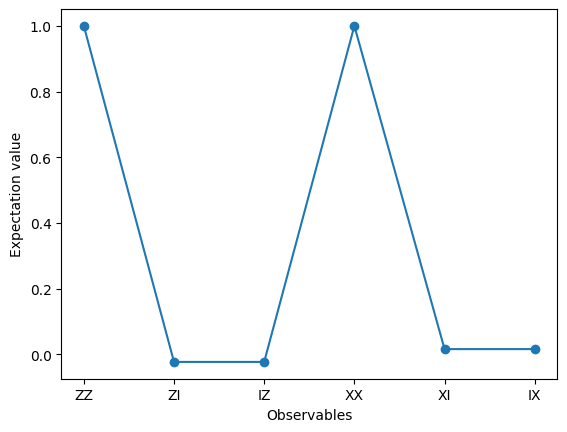

In [6]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

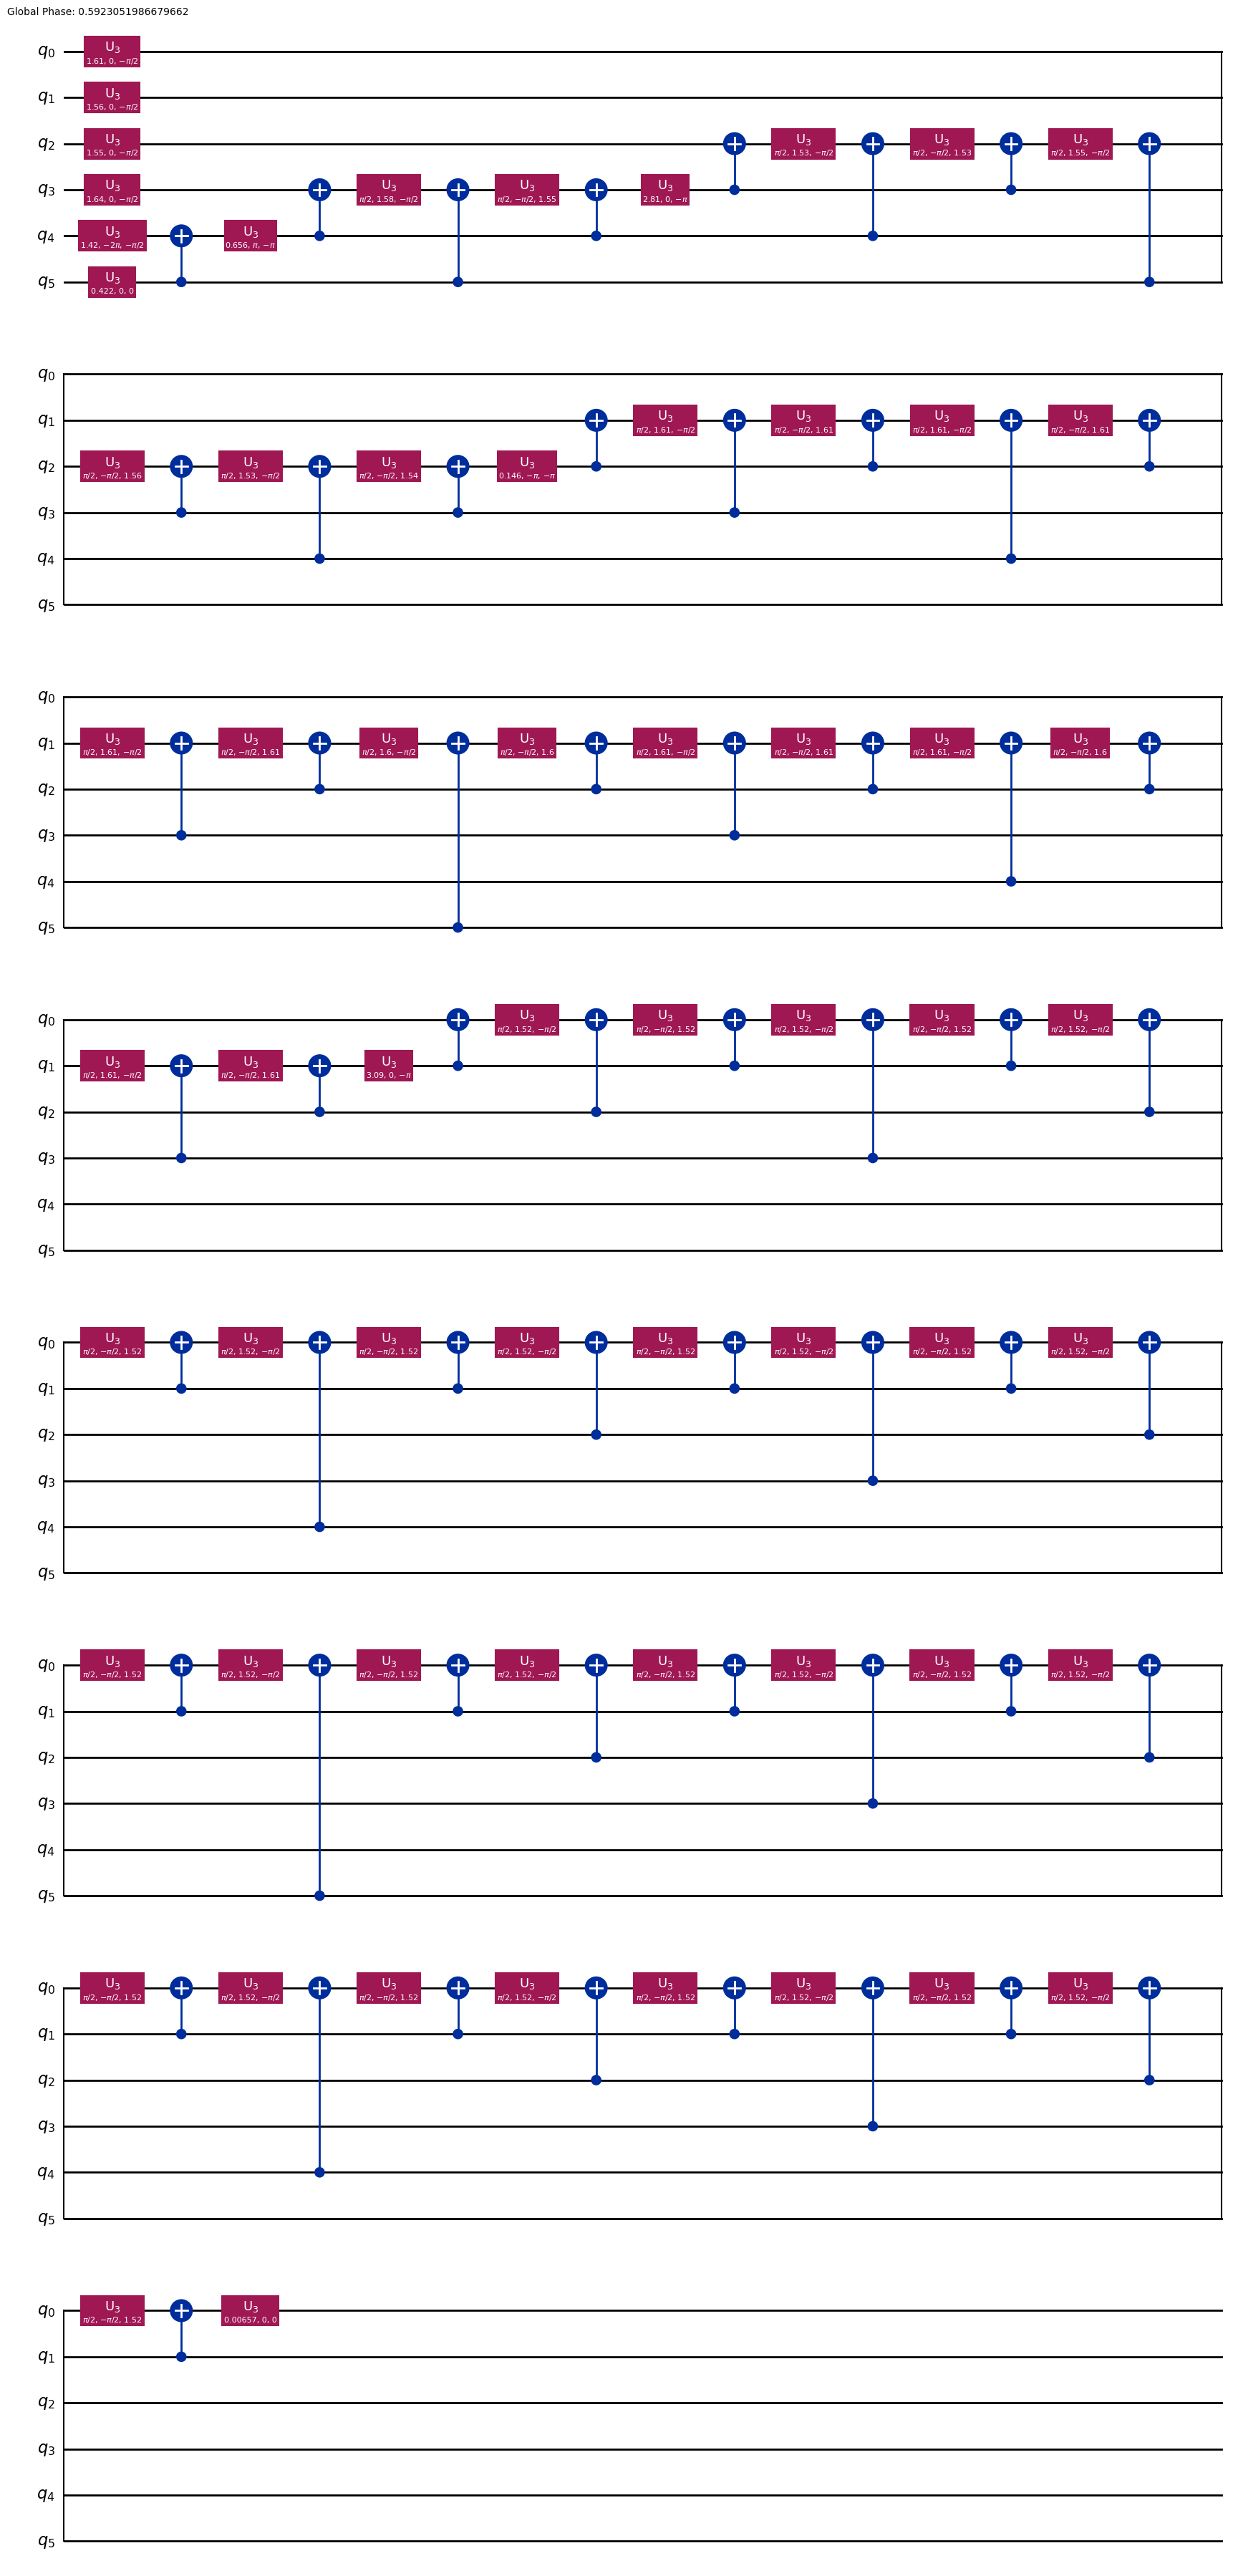

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 6  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
x_vals = np.linspace(domain_min, domain_max, N)

# Calculate probabilities for state preparation
probabilities = np.array([lognormal_loss(x) for x in x_vals])
normalizing_constant = np.sum(probabilities)
probabilities /= normalizing_constant

# Full distribution for visualization
full_x_vals = np.linspace(domain_min, domain_max, 10_000)
full_probabilities = np.array([lognormal_loss(x) for x in full_x_vals])
full_normalizing_constant = np.sum(full_probabilities) * N / 10_000
full_probabilities /= full_normalizing_constant

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
qc.draw(output='mpl')

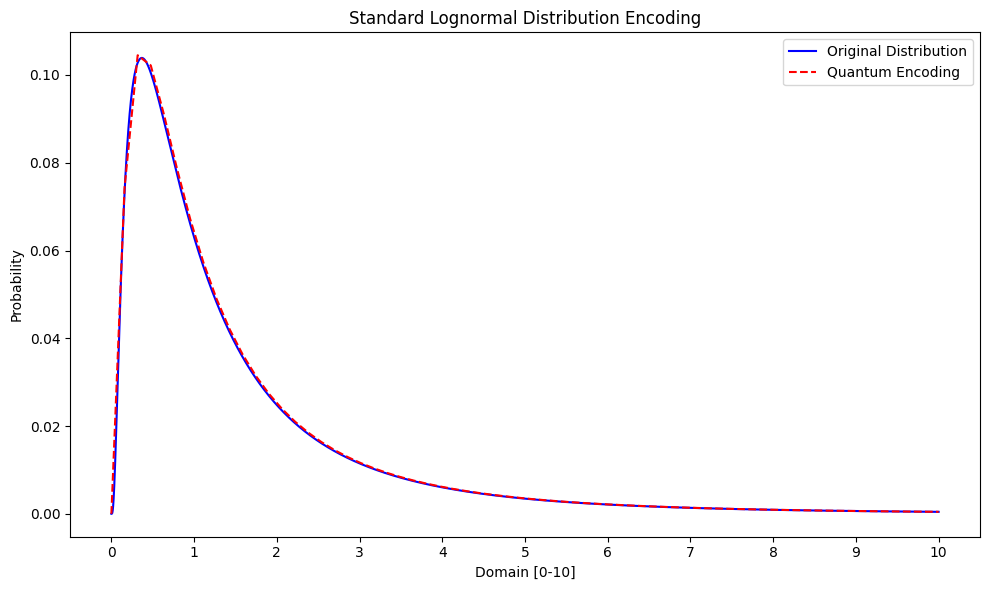

First 10 amplitudes:
State |0⟩: √p_j = 0.000000, p_j = 0.000000
State |1⟩: √p_j = 0.272392, p_j = 0.074197
State |2⟩: √p_j = 0.323254, p_j = 0.104493
State |3⟩: √p_j = 0.319649, p_j = 0.102175
State |4⟩: √p_j = 0.301694, p_j = 0.091019
State |5⟩: √p_j = 0.280360, p_j = 0.078602
State |6⟩: √p_j = 0.259219, p_j = 0.067194
State |7⟩: √p_j = 0.239467, p_j = 0.057344
State |8⟩: √p_j = 0.221441, p_j = 0.049036
State |9⟩: √p_j = 0.205148, p_j = 0.042086


In [ ]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities, 'b-', label='Original Distribution')
plt.plot(x_vals, measured_probs, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.show()

# Display the first few amplitudes
print("First 10 amplitudes:")
for i in range(10):
    print(
        f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")